# Replica paper skin (ISIC2017)
### Progress

- **Tradicional features**
  - [x] Color moment features
  - [x] Texture features
  - [ ] SVM with tradicional features only
- **Deep features**: Coding network (CNN)
  - [x] Create network architecture
  - [ ] Train
- **Fusion methods**
  - [ ] CNMP (multilayer perceptron as fusion method)
  - [ ] R feature fusion (manully fixed parameter)
  - [ ] KPCA feature fusion
  - [ ] SVM feature fusion (SVM as fusion method)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision import *

from numba import jit
import numpy as np
import pathlib
import pandas as pd
import PIL
#import cv2
from tqdm import tqdm
from scipy.stats import skew, kurtosis                         # Color feature (3rd moment)
from skimage.feature.texture import greycomatrix, greycoprops  # Texture features
from skimage.measure import shannon_entropy                    # Texture features (entropy)
from sklearn.svm import SVC                                    # Support vector machine
from sklearn.model_selection import StratifiedKFold            # Stratified cross validation
from sklearn import metrics

# Pytorch dataset

In [16]:
class SkinDataset(torch.utils.data.Dataset):

	def __init__(self, subset, transforms=False):
		dataset_dir = pathlib.Path("E:/Datasets/TFM/ISIC-2017")
		csv_file    = dataset_dir / ("ground_truth_"+subset+".csv")
		csv_df      = pd.read_csv(csv_file)

		self.image_dir  = dataset_dir / ("data_"+subset)
		self.images     = (csv_df["image_id"]+".jpg").values
		self.labels1    = (csv_df["melanoma"]).values
		self.labels2    = (csv_df["seborrheic_keratosis"]).values
		self.labels_map = {0:"melanoma", 1:"seborrheic", 2:"healthy"}
		self.transforms = transforms
        
	def __len__(self):
		return len(self.labels1)

	def __getitem__(self, idx):
		img_name = self.image_dir / self.images[idx]
		image = PIL.Image.open(img_name)
		if self.transforms: image = self.transforms(image)
		label = self.labels1[idx]
		return image, label

skin_ds    = {subset: SkinDataset(subset) for subset in ["train", "valid", "test"]}
{print("There are", len(skin_ds[subset]), "images in the "+subset+" dataset.") for subset in ["train", "valid", "test"]};

There are 2000 images in the train dataset.
There are 150 images in the valid dataset.
There are 600 images in the test dataset.


# Fastai data

In [2]:
path     = pathlib.Path("E:/Datasets/TFM/ISIC-2017")
df_train = pd.read_csv(path / ("ground_truth_train.csv"))
df_valid = pd.read_csv(path / ("ground_truth_valid.csv"))
df_test  = pd.read_csv(path / ("ground_truth_test.csv"))

df_train = df_train.replace({'melanoma': {0.0:"no", 1.0:"yes"}})
df_valid = df_valid.replace({'melanoma': {0.0:"no", 1.0:"yes"}})
df_test  =  df_test.replace({'melanoma': {0.0:"no", 1.0:"yes"}})
df_train = df_train.replace({'seborrheic_keratosis': {0.0:"no", 1.0:"yes"}})
df_valid = df_valid.replace({'seborrheic_keratosis': {0.0:"no", 1.0:"yes"}})
df_test  =  df_test.replace({'seborrheic_keratosis': {0.0:"no", 1.0:"yes"}})

# Merge
#df = pd.concat([df_train, df_valid, df_test], ignore_index=True)
#df = df.replace({'melanoma': {0.0:"no", 1.0:"yes"}})
#df = df.replace({'seborrheic_keratosis': {0.0:"no", 1.0:"yes"}})
#src  = ImageItemList.from_df(df, path, suffix=".jpg")

df_train.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,no,no
1,ISIC_0000001,no,no
2,ISIC_0000002,yes,no
3,ISIC_0000003,no,no
4,ISIC_0000004,yes,no


In [7]:
ISIC2017_mean  = [0.689854, 0.585559, 0.543878]
ISIC2017_std   = [0.10585 , 0.114173, 0.127212]

train = ImageItemList.from_df(df_train, path, folder='data_train', suffix=".jpg")
valid = ImageItemList.from_df(df_valid, path, folder='data_valid', suffix=".jpg")
test  = ImageItemList.from_df(df_test,  path, folder='data_test',  suffix=".jpg")

src       = train.no_split()
src.valid = valid
#src.test  = test
data = (src.label_from_df(cols='melanoma')
        .transform(get_transforms(flip_vert=True, max_warp=None), size=140)
        .databunch(bs=16)
        .normalize((ISIC2017_mean, ISIC2017_std)))

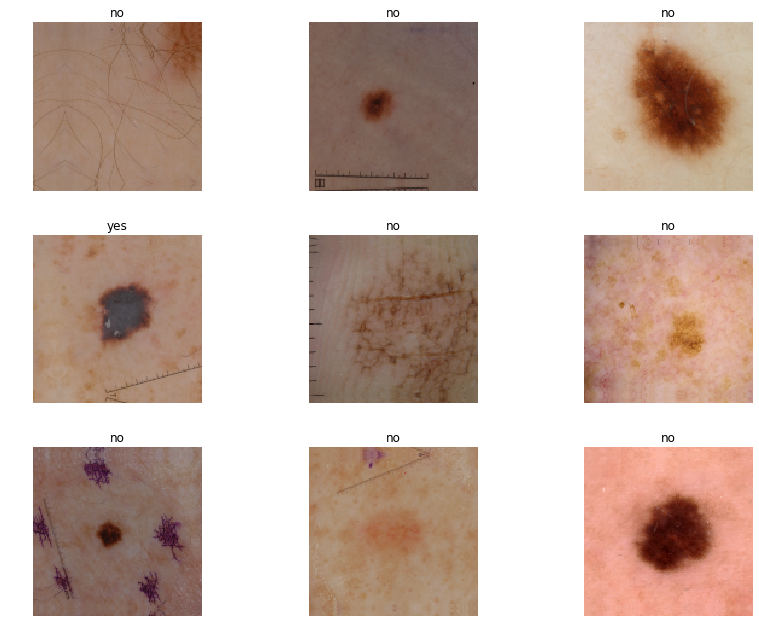

In [4]:
data.show_batch(rows=3, figsize=(12,9))

In [17]:
###################################### Get mean and std
#mean = np.zeros(3)  # float64
#std  = np.zeros(3)  # float64
#for img in tqdm(train):
#    mean += img.data.numpy().mean(axis=(1,2)) # float32
#    std  += img.data.numpy().std(axis=(1,2)) 
#mean /= len(train)
#std  /= len(train)

# Traditional features


#### Texture features

1. First acquire the gray-level co-occurrence matrix G (2 distances, 4 angles = 2*4 = 8 matrices)
2. Then, we employ:
   - **Angular second moment** (ASM)
   - **Entropy** (ENT)
   - **Contrast** (CON)
   - **Correlation** (COR)
   

8 matrices * 4 features each = 32 total features


### Color moment features

For each RGB channel compute:
- First color moment (**Mean**)
- Second color moment (**Std**)
- Third color moment (**Skewness**)

In [31]:
from scipy.stats import skew, kurtosis                         # Color feature (3rd moment)
from skimage.feature.texture import greycomatrix, greycoprops  # Texture features
from skimage.measure import shannon_entropy                    # Texture features (entropy)

def texture_features(pil_img):
    
    # Read image in black and white (np array of 2 dimensions)
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # A bit different b&w values
    img = pil_img.convert("L")
    img = np.array(img)

    # Get Gray-Level Co-Occurrence Matrix from the image (2 distances, 4 angles = 2*4 = 8 matrices)
    distances  = [1,2]
    angles     = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degree in radians.
    glcm = greycomatrix(img, distances, angles)
    #print("GLCM shape:", glcm.shape)

    # Get properties from glcm. (Entropy feature is not available in the greycoprops method)
    properties = ['ASM', 'contrast'] #properties = ['ASM', 'contrast', 'correlation']
    some_texture_feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])

    entropy_feat = [shannon_entropy(glcm[:,:,x,y])  for x in range(2)   for y in range(4)]

    return np.hstack([some_texture_feats, entropy_feat])
    
def color_features(pil_img):

    np_image = np.array(pil_img)
    mean     = np.mean(np_image, axis=(0,1))                           # First color moment (Mean)
    std      = np.std(np_image, axis=(0,1))                            # Second color moment (std)
    skewness = [skew(np_image[:, :, c].reshape(-1)) for c in range(3)] # Third color moment (Skewness)

    return np.hstack([mean, std, skewness])

def traditional_features(dataset):
    
    num_samples = len(dataset)     # 5
    
    x = np.empty([num_samples, 33]) # 41
    y = np.empty([num_samples])
    
    for i in tqdm(range(num_samples)):
        image = dataset[i][0]
        label = dataset[i][1]
        x[i]  = np.hstack([texture_features(image), color_features(image)])
        y[i]  = label
        
    return x, y

## Check y class
x,y = traditional_features(skin_ds["train"]); np.save('skinTrain_x_low.npy', x); np.save('skinTrain_y.npy', y.astype(int))
#x,y = traditional_features(skin_ds["valid"]); np.save('skinValid_x_low.npy', x); np.save('skinValid_y.npy', y.astype(int))
# x,y = traditional_features(skin_ds["test"]); np.save('skinTest_x_low.npy', x); np.save('skinTest_y.npy', y.astype(int))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [45:20<00:00,  5.84s/it]


# SVM with traditional features

- [scikit-learn](https://scikit-learn.org/stable/modules/svm.html)
- [datacamp](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)
- [dealing with imbalanced classes](https://chrisalbon.com/machine_learning/support_vector_machines/imbalanced_classes_in_svm/)

In [5]:
cross_valid = StratifiedKFold(n_splits=10)
x = np.load('traditionalFeats/his_x.npy')
y = np.load('traditionalFeats/his_y.npy')
print("Data shape: x =",x.shape, "y =", y.shape)

for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    
    ########################################################## GET K-FOLD DATA
    x_train, y_train = x[train_index], y[train_index]
    x_valid, y_valid = x[valid_index], y[valid_index]
    
    ########################################################## TRAIN
    #svm = SVC(class_weight='balanced', C=1.0, gamma='auto')    # SVM with RBF Kernel
    svm = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=0, gamma='scale')
    svm.fit(x_train, y_train)  # Train the SVM
     
    ########################################################## EVALUATE
    y_pred = svm.predict(x_valid) # Predict the response for test dataset
    print("================================ Fold", i+1)
    print("Accuracy:",         metrics.accuracy_score(y_valid, y_pred))
    print("Confusion matrix:\n", metrics.confusion_matrix(y_valid, y_pred))
    #print("\tPrecision:", metrics.precision_score(y_valid, y_pred))
    #print("\tRecall:",    metrics.recall_score(y_valid, y_pred))

Data shape: x = (2828, 33) y = (2828,)
================================ Fold 1
Accuracy: 0.28771929824561404
Confusion matrix:
 [[  0  49   0   0]
 [  0  81   0   0]
 [  0  51   1   0]
 [  0 103   0   0]]
================================ Fold 2
Accuracy: 0.28421052631578947
Confusion matrix:
 [[  0  49   0   0]
 [  0  81   0   0]
 [  0  52   0   0]
 [  0 103   0   0]]
================================ Fold 3
Accuracy: 0.28421052631578947
Confusion matrix:
 [[  0  49   0   0]
 [  0  81   0   0]
 [  0  52   0   0]
 [  0 103   0   0]]
================================ Fold 4
Accuracy: 0.28421052631578947
Confusion matrix:
 [[  0  49   0   0]
 [  0  81   0   0]
 [  0  52   0   0]
 [  0 103   0   0]]
================================ Fold 5
Accuracy: 0.36524822695035464
Confusion matrix:
 [[  0   0   0  48]
 [  0   0   0  80]
 [  0   0   0  51]
 [  0   0   0 103]]
================================ Fold 6
Accuracy: 0.36879432624113473
Confusion matrix:
 [[  0   0   0  48]
 [  0   0   0  80]
 [  

In [8]:
211+30+25+29+20+394+28+59+19+35+241+18+21+42+27+497

1696

In [7]:
2828*0.6

1696.8

# Coding Network architecture

- [Custom model with fast.ai](https://forums.fast.ai/t/so-you-want-to-create-your-custom-pipeline-with-fastai/17182/11)


Input size of `3×140×140`

Layer       | Kernel | Stride | Output size
------------|--------|--------|------------
Convolution | 11×11  |    1   | 32×130×130
Convolution | 11×11  |    1   | 32×120×120
Max pooling | 5×5    |    2   | 32×58×58
Convolution | 9×9    |    1   | 64×50×50
Max pooling | 5×5    |    2   | 64×23×23
Convolution | 8×8    |    1   | 128×16×16
Convolution | 9×9    |    1   | 256×8×8
Convolution | 8×8    |    1   | 256×1×1
Dense       |    -   |    -   | 4×1×1
Softmax     |    -   |    -   | 4×1×1

In [4]:
class CodingNetwork(nn.Module):
    
    #Our batch shape for input x is (3, 140, 140)
    
    def __init__(self):
        super(CodingNetwork, self).__init__()
        
        #Input channels=3, output channels=32
        self.conv1 = nn.Conv2d(3,  32, kernel_size=11, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=11, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=9, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=5, stride=2, padding=0)

        self.conv4 = nn.Conv2d(64,  128, kernel_size=8, stride=1, padding=0)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=9, stride=1, padding=0)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=8, stride=1, padding=0)

        #4608 input features, 64 output features (see sizing flow below)
        self.fc = nn.Linear(256, 4)

    def forward(self, x):
        
        #Computes the activation of the first convolution
        
        x = F.relu(self.conv1(x)) # Size changes from (3, 140, 140) to (32, 130, 130)
        x = F.relu(self.conv2(x)) # Size changes from (32, 130, 130) to (32, 120, 120)
        x = self.pool1(x)         # Size changes from (32, 120, 120) to (32, 58, 58)

        x = F.relu(self.conv3(x)) # Size changes from (32, 58, 58) to (64, 50, 50)
        x = self.pool2(x)         # Size changes from (64, 50, 50) to (64, 23, 23)

        x = F.relu(self.conv4(x)) # Size changes from (64, 23, 23) to (128, 16, 16)
        x = F.relu(self.conv5(x)) # Size changes from (128, 16, 16) to (256, 8, 8)
        x = F.relu(self.conv6(x)) # Size changes from (256, 8, 8) to (256, 1, 1)

        x = x.view(-1, 256)       # Size changes from (256, 1, 1) to (256)
        x = self.fc(x)            # Size changes from (256) to (4)
        
        return(x)

In [5]:
model = CodingNetwork()

x = torch.randn(16, 3, 140, 140)
output = model(x)


learn = Learner(my_data_bunch, model, metrics=accuracy)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train

In [6]:
mean       = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
std        = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]
train_tmfs =  transforms.Compose([transforms.RandomCrop(420),
                                  transforms.Resize(140),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std)])

micro_ds.transforms = train_tmfs
trainloader = torch.utils.data.DataLoader(micro_ds, batch_size=64, shuffle=True)

##################################### TRAIN WITH SKORCH
net = NeuralNetClassifier(
    CodingNetwork,
    max_epochs=10,
    lr=0.1,
    batch_size=64
    dataset
    device='cuda'
)

net.fit(X=micro_ds, y=None)
#y_proba = net.predict_proba(X)

ValueError: Stratified CV requires explicitely passing a suitable y.